### 1. Setup environment

In [2]:
# This section sets up the environment by running the environment setup script, which ensures that all required libraries and configurations are loaded.
%run 0-Environment_Setup.ipynb

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


### 2. Set session variables

In [3]:
# This section initializes the session variables required for interacting with SageMaker, such as the session, role, region, and default S3 bucket for storing data.
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_session.region_name
bucket = sagemaker_session.default_bucket()

train_prefix = "store-sales-forecasting/train"
test_prefix = "store-sales-forecasting/test"
val_prefix = "store-sales-forecasting/val"

### 3. Create a temporary directory for saving data

In [4]:
# This section creates a temporary directory to store local data files before uploading them to S3.
local_path = f"{os.getcwd()}/tmp"
if not os.path.exists(local_path):
    os.makedirs(local_path)


### 4. Load data splits from S3

In [5]:
# This section downloads the preprocessed training, testing, and validation data splits from S3.
s3 = boto3.client('s3')

# Download the files from S3
s3.download_file(bucket, f"{train_prefix}/X_train.npy", f"{local_path}/X_train.npy")
s3.download_file(bucket, f"{train_prefix}/y_train.npy", f"{local_path}/y_train.npy")
s3.download_file(bucket, f"{test_prefix}/X_test.npy", f"{local_path}/X_test.npy")
s3.download_file(bucket, f"{test_prefix}/y_test.npy", f"{local_path}/y_test.npy")
s3.download_file(bucket, f"{val_prefix}/X_val.npy", f"{local_path}/X_val.npy")
s3.download_file(bucket, f"{val_prefix}/y_val.npy", f"{local_path}/y_val.npy")

# Load the data splits
X_train = np.load(f"{local_path}/X_train.npy")
y_train = np.load(f"{local_path}/y_train.npy")
X_test = np.load(f"{local_path}/X_test.npy")
y_test = np.load(f"{local_path}/y_test.npy")
X_val = np.load(f"{local_path}/X_val.npy")
y_val = np.load(f"{local_path}/y_val.npy")

### 5. Set up rolling window input-output shapes

In [6]:
# Set the input and target sequence lengths, ensuring they match the preparation notebook configuration.
input_seq_length = 60
target_seq_length = 7

# Check the shapes of the loaded data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (69897, 60, 25), y_train shape: (69897, 7)
X_test shape: (8737, 60, 25), y_test shape: (8737, 7)
X_val shape: (8738, 60, 25), y_val shape: (8738, 7)


### 6. Define the Baseline Model

In [7]:
# This section defines a simple baseline linear regression model to establish a performance baseline.
from sklearn.linear_model import LinearRegression

# Reshape the data for linear regression (flatten time and features)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)

# Define linear regression model
model = LinearRegression()

# Fit the model using training data
model.fit(X_train_reshaped, y_train)


LinearRegression()

### 7. Evaluate Model Performance

In [8]:
# Evaluate the model on the test set to get an unbiased estimate of model performance.
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the test set
y_pred = model.predict(X_test_reshaped)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE: {mse}, Test MAE: {mae}")

Test MSE: 3.3265844967576393e+31, Test MAE: 4482546015235201.5


The high MSE and MAE values indicate that our baseline model's performance is poor, suggesting that the a simple linear regression model may not be well-suited to capture the complex relationships in the sales data.

We can still use this model performace to benchmark the results of our other two mdodel approches, to evalute the best solution for our store prediction

### 8. Plot Actual vs Predicted Sales

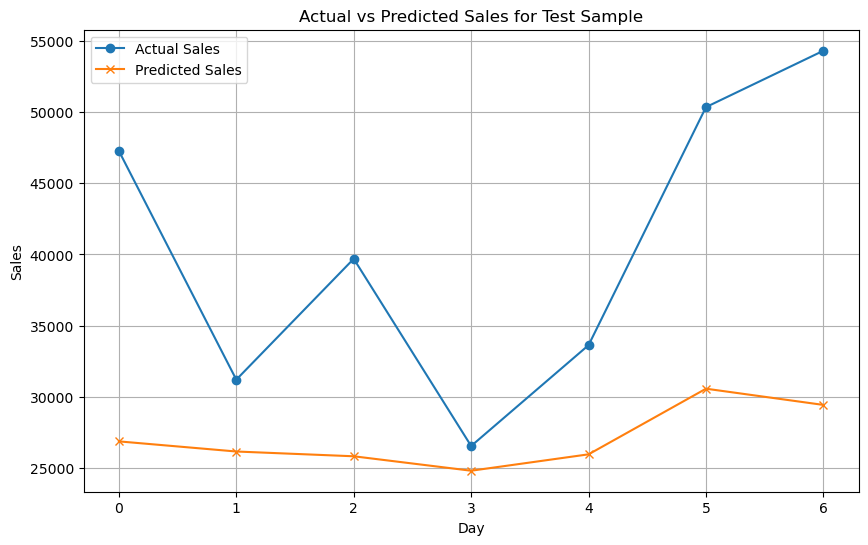

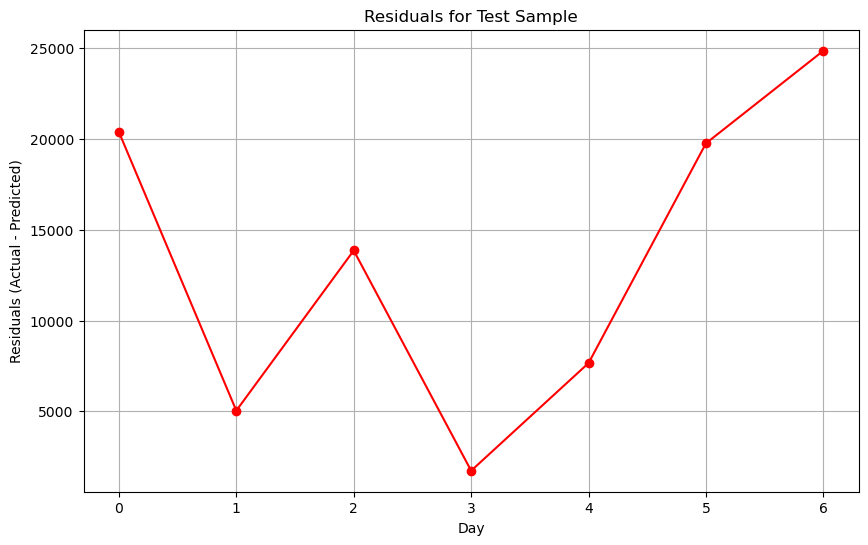

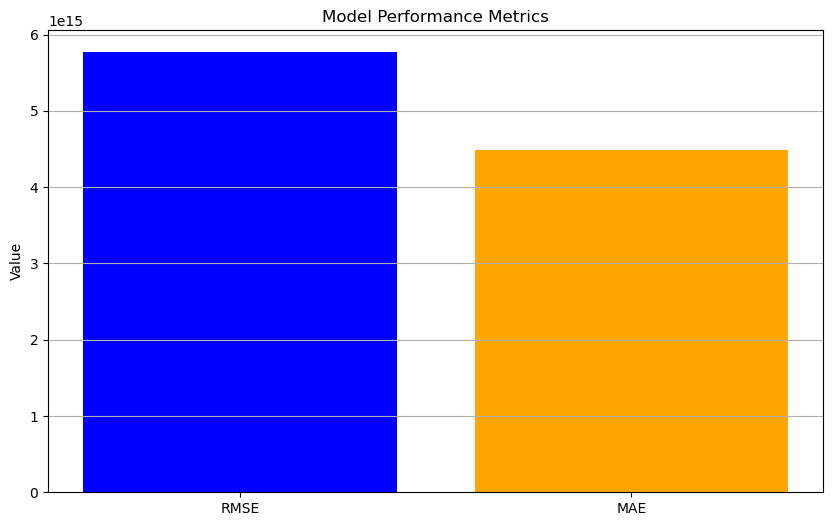

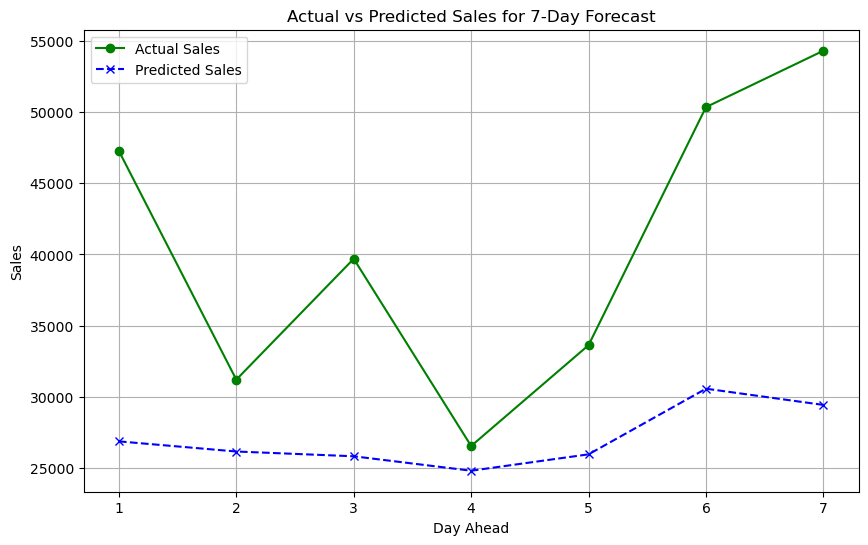

In [9]:
# Plot actual vs. predicted sales for a sample of the test set to visualize model performance.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test[0], label='Actual Sales', marker='o')
plt.plot(y_pred[0], label='Predicted Sales', marker='x')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.legend()
plt.title('Actual vs Predicted Sales for Test Sample')
plt.grid(True)
plt.show()

# Plot Residuals
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.plot(residuals[0], marker='o', linestyle='-', color='red')
plt.xlabel('Day')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for Test Sample')
plt.grid(True)
plt.show()

# Plot RMSE and MAE Metrics
plt.figure(figsize=(10, 6))
metrics = {'RMSE': np.sqrt(mse), 'MAE': mae}
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange'])
plt.title('Model Performance Metrics')
plt.ylabel('Value')
plt.grid(axis='y')
plt.show()

# Plot Actual vs Predicted for Entire 7-Day Forecast
plt.figure(figsize=(10, 6))
plt.plot(range(1, target_seq_length + 1), y_test[0], label='Actual Sales', marker='o', linestyle='-', color='green')
plt.plot(range(1, target_seq_length + 1), y_pred[0], label='Predicted Sales', marker='x', linestyle='--', color='blue')
plt.xlabel('Day Ahead')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales for 7-Day Forecast')
plt.legend()
plt.grid(True)
plt.show()

### 9. Save the Model

In [10]:
# Save the trained model to the local path, then upload it to S3 for deployment purposes.
import joblib

joblib.dump(model, f"{local_path}/sales_forecast_linear_model.pkl")
sagemaker_session.upload_data(f"{local_path}/sales_forecast_linear_model.pkl", bucket=bucket, key_prefix=train_prefix)
's3://sagemaker-us-east-2-612877486901/store-sales-forecasting/train/sales_forecast_linear_model.pkl'

's3://sagemaker-us-east-2-612877486901/store-sales-forecasting/train/sales_forecast_linear_model.pkl'

### 10. Make Future Predictions

            Predicted Sales
2017-08-16     26916.759203
2017-08-17     26171.165667
2017-08-18     25868.008252
2017-08-19     24852.365466
2017-08-20     26043.097259
2017-08-21     30610.409535
2017-08-22     29453.453123


<Figure size 1000x600 with 0 Axes>

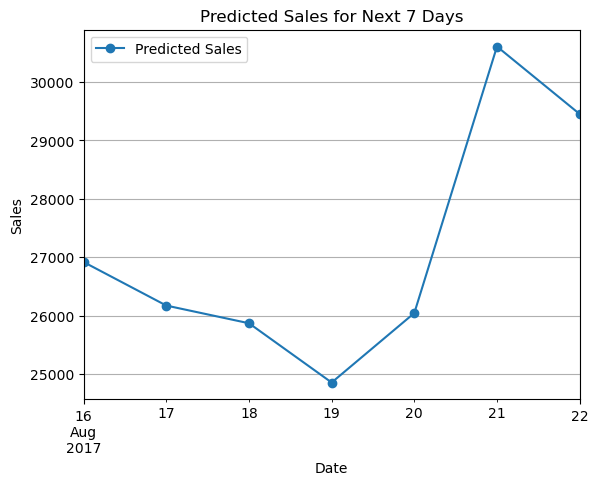

In [25]:
# Predict sales for the next 7 days using test data as an example.
import pandas as pd

# Take an example input sequence from the test set
example_input = X_test_reshaped[0:1]

# Predict the sales for the next 7 days
predicted_sales = model.predict(example_input)

# Prepare a DataFrame for better visualization of predictions
prediction_dates = pd.date_range(start='2017-08-16', periods=target_seq_length, freq='D')
predicted_sales_df = pd.DataFrame(predicted_sales.reshape(-1, 1), index=prediction_dates, columns=['Predicted Sales'])

print(predicted_sales_df)

plt.figure(figsize=(10, 6))
predicted_sales_df.plot(marker='o')
plt.title('Predicted Sales for Next 7 Days')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(True)
plt.show()

            Predicted Sales  Actual Sales
2017-08-16     26916.759203      47262.68
2017-08-17     26171.165667      31216.80
2017-08-18     25868.008252      39696.26
2017-08-19     24852.365466      26562.92
2017-08-20     26043.097259      33638.37
2017-08-21     30610.409535      50336.99
2017-08-22     29453.453123      54292.43


<Figure size 1000x600 with 0 Axes>

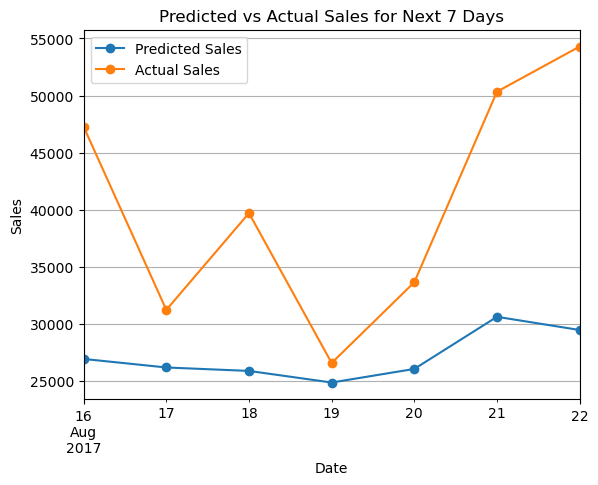

In [27]:

# Predict sales for the next 7 days using test data as an example.
import pandas as pd

# Take an example input sequence from the test set
example_input = X_test_reshaped[0:1]

# Predict the sales for the next 7 days
predicted_sales = model.predict(example_input)

# Get the actual sales for comparison
actual_sales = y_test[0]

# Prepare a DataFrame for better visualization of predictions and actual sales
prediction_dates = pd.date_range(start='2017-08-16', periods=target_seq_length, freq='D')
predicted_sales_df = pd.DataFrame({'Predicted Sales': predicted_sales.reshape(-1), 'Actual Sales': actual_sales}, index=prediction_dates)

print(predicted_sales_df)

# Plot the predicted and actual sales
plt.figure(figsize=(10, 6))
predicted_sales_df.plot(marker='o')
plt.title('Predicted vs Actual Sales for Next 7 Days')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(True)
plt.show()

### Make Future Predictions for the first 10 Stores

<Figure size 1000x600 with 0 Axes>

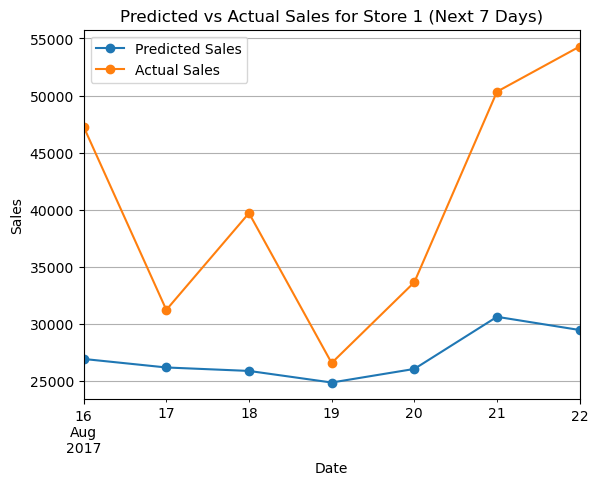

<Figure size 1000x600 with 0 Axes>

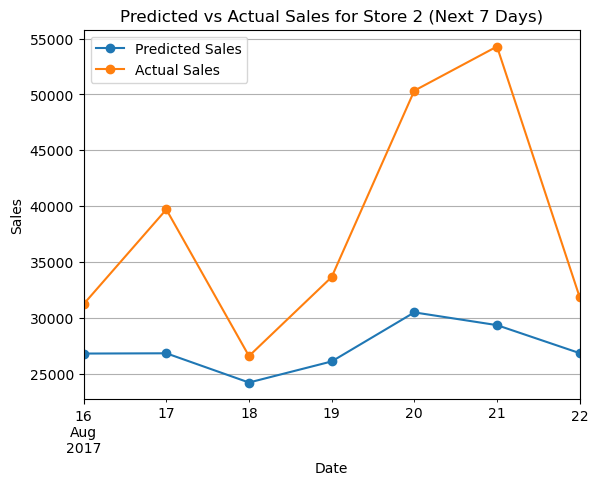

<Figure size 1000x600 with 0 Axes>

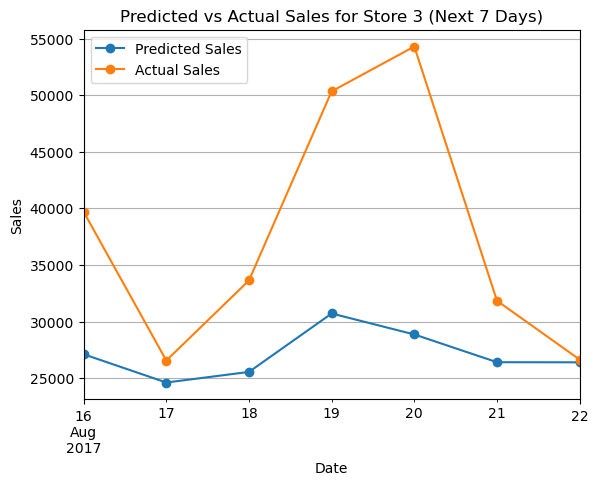

<Figure size 1000x600 with 0 Axes>

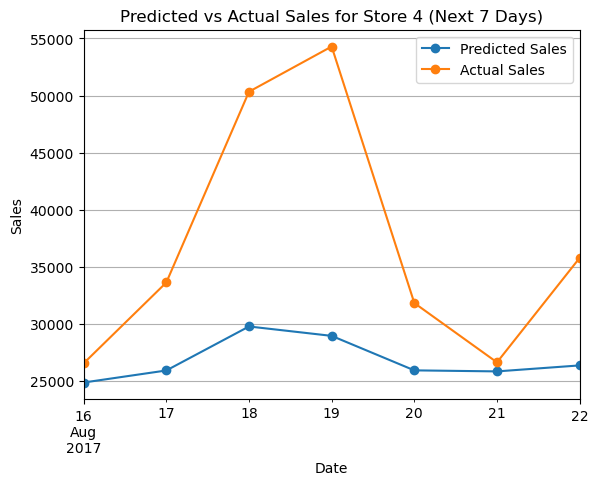

<Figure size 1000x600 with 0 Axes>

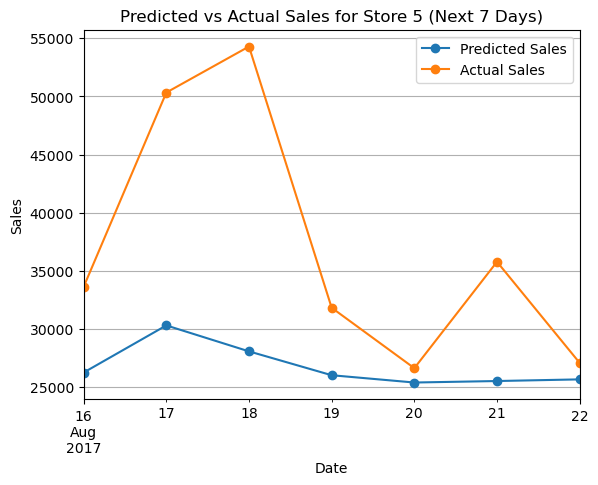

<Figure size 1000x600 with 0 Axes>

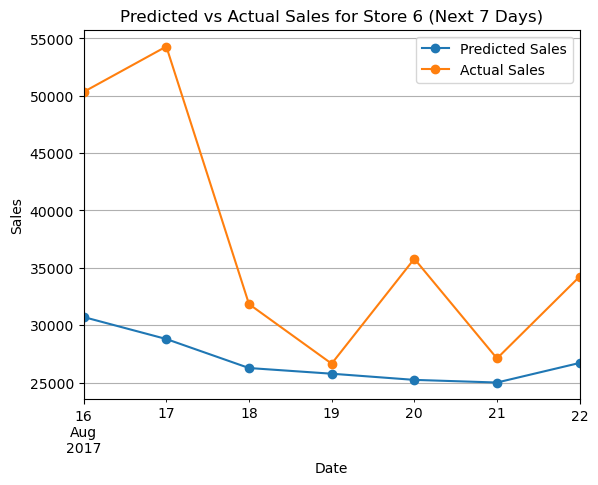

<Figure size 1000x600 with 0 Axes>

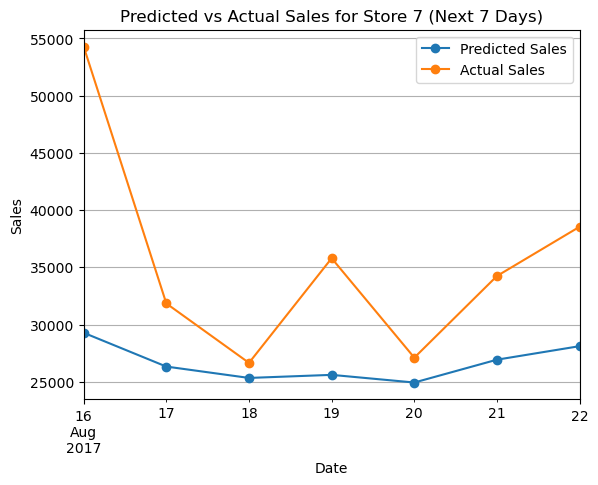

<Figure size 1000x600 with 0 Axes>

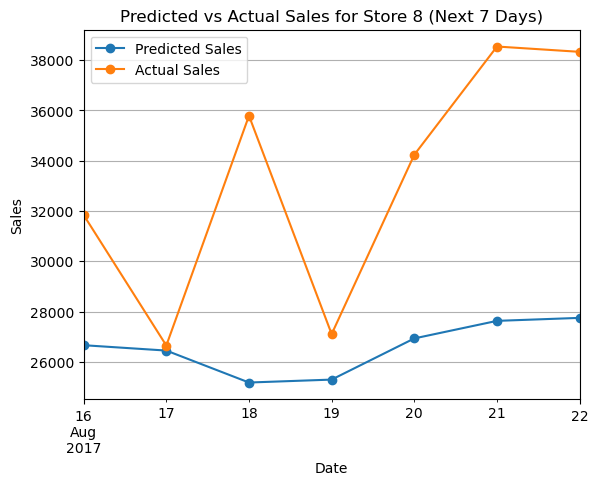

<Figure size 1000x600 with 0 Axes>

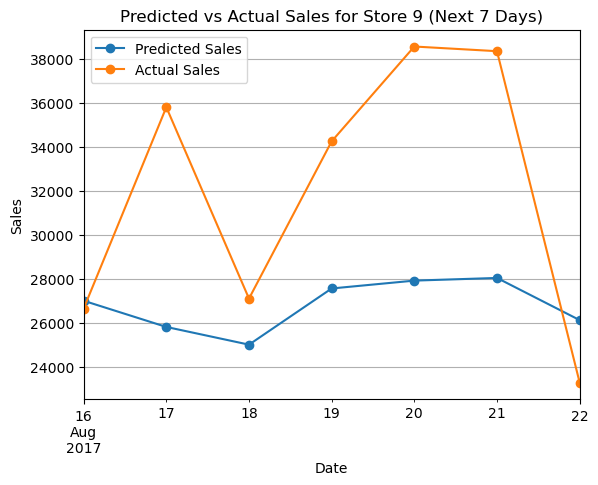

<Figure size 1000x600 with 0 Axes>

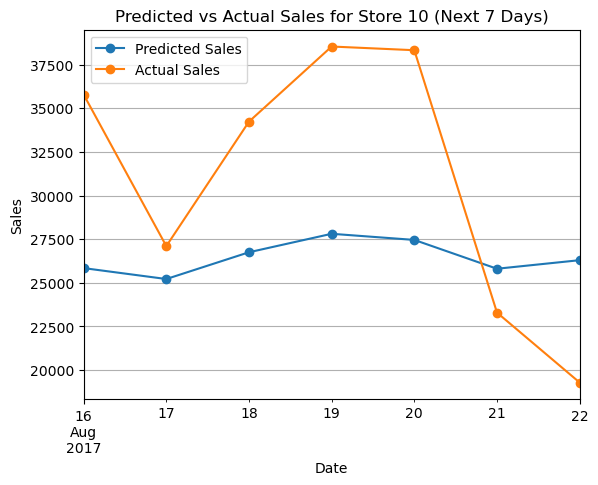

In [18]:
for store_idx in range(10):
    example_input = X_test_reshaped[store_idx:store_idx + 1]
    predicted_sales = model.predict(example_input)
    actual_sales = y_test[store_idx]

    prediction_dates = pd.date_range(start='2017-08-16', periods=target_seq_length, freq='D')
    predicted_sales_df = pd.DataFrame({'Predicted Sales': predicted_sales.reshape(-1), 'Actual Sales': actual_sales}, index=prediction_dates)

    # Plot the predicted and actual sales
    plt.figure(figsize=(10, 6))
    predicted_sales_df.plot(marker='o')
    plt.title(f'Predicted vs Actual Sales for Store {store_idx + 1} (Next 7 Days)')
    plt.ylabel('Sales')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

As we can see the predicted sales compared to the actual values indicate that the baseline linear regression model struggles to capture the full complexity of sales dynamics, as evidenced by the large discrepancies. 

However, these results can provide a starting point and performance benchmark for comparing with more sophisticated models, such as Deep AR or the custome time seriers deep learning approaches, we plan to explore. These future models should ideally show a significant reduction in error and improve prediction accuracy over the baseline.

